In [1]:
from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
from bioinformatics import na_read
from bioinformatics import KmerVectors as kvec
from bioinformatics import NCBIDataset as nds
from bioinformatics import FASTADataset as fads

In [3]:
RDP_PATH="../data/bioinformatics/rdp/202208/"
#!ls -al $RDP_PATH
#RAND_PATH="../data/bioinformatics/"

In [4]:
#!ls -al $RDP_PATH
archaea_file = RDP_PATH + "current_Archaea_unaligned.fa"
bacteria_file = RDP_PATH + "current_Bacteria_unaligned.fa"
fungi_file = RDP_PATH + "current_Fungi_unaligned.fa"
#!ls -al $archaea_file

#random1_file = RAND_PATH + "random-1.fa"
#random2_file = RAND_PATH + "random-2.fa"

In [5]:
archaea_fads = fads.FASTADataset('archaea', archaea_file)
print(f'archaea: [{len(archaea_fads.fasta_dataset)}]')
#archaea.fasta_dataset
bacteria_fads = fads.FASTADataset('bacteria', bacteria_file)
print(f'bacteria: [{len(bacteria_fads.fasta_dataset)}]')
#fungi_fads = fads.FASTADataset('fungi', fungi_file)
#print(f'fungi: [{len(fungi_fads.fasta_dataset)}]')
#random1_fads = fads.FASTADataset('random-1', random1_file)
#random2_fads = fads.FASTADataset('random-2', random2_file)

archaea: [160767]
bacteria: [3196041]


In [6]:
#kv = kvec.KmerVectors(['A','G','C','T'], 8, fastadatasets=[archaea_fads, fungi_fads])
kv = kvec.KmerVectors(['A','G','C','T'], 8, fastadatasets=[archaea_fads, bacteria_fads])
#kv = kvec.KmerVectors(['A','G','C','T'], 8, fastadatasets=[random1_fads, random2_fads])
print(kv.labels)

KmerVectors Object -
alphabet [['A', 'G', 'C', 'T']]
dict: [['AAAAAAAA', 'AAAAAAAG', 'AAAAAAAC', 'AAAAAAAT']]...[['TTTTTTTA', 'TTTTTTTG', 'TTTTTTTC', 'TTTTTTTT']]
Labels: [{'archaea': 1, 'bacteria': 2}]
[archaea]
[../data/bioinformatics/rdp/202208/current_Archaea_unaligned.fa]
[bacteria]
[../data/bioinformatics/rdp/202208/current_Bacteria_unaligned.fa]
{'archaea': 1, 'bacteria': 2}


In [7]:
d = kv.seq2KmerSentences(base_count_max=4, length_min=1400, dataset_limit=10000)

FASTA Dataset
fasta dataset: [archaea]
100020003000400050006000700080009000100001100012000130001400015000160001700018000190002000021000220002300024000250002600027000280002900030000310003200033000340003500036000370003800039000400004100042000430004400045000460004700048000490005000051000520005300054000550005600057000580005900060000610006200063000640006500066000670006800069000700007100072000730007400075000760007700078000790008000081000820008300084000850008600087000880008900090000910009200093000940009500096000970009800099000100000101000102000103000104000105000106000107000108000109000110000111000112000113000114000115000116000117000118000119000120000121000122000123000124000125000126000127000128000129000130000131000132000133000134000135000136000137000138000139000140000141000142000143000144000145000146000147000148000149000150000151000152000153000154000155000156000157000158000capped at [10000]
-
Total:                [158350]
Using :               [10001]
skip_count_minlength: [11986]
skip_count

In [8]:
df=pd.DataFrame(data=d)
df

,v1,v2
0,archaea,ACTCCGGT CTCCGGTT TCCGGTTG CCGGTTGA CGGTTGAT G...
1,archaea,CCCGACTG CCGACTGC CGACTGCT GACTGCTA ACTGCTAT C...
2,archaea,ACTCCGGT CTCCGGTT TCCGGTTG CCGGTTGA CGGTTGAT G...
3,archaea,GGACCTGA GACCTGAC ACCTGACT CCTGACTG CTGACTGC T...
4,archaea,ACTCCGGT CTCCGGTT TCCGGTTG CCGGTTGA CGGTTGAT G...
...,...,...
19995,bacteria,TACCAGTC ACCAGTCC CCAGTCCT CAGTCCTT AGTCCTTA G...
19996,bacteria,CTGACCTC TGACCTCA GACCTCAA ACCTCAAT CCTCAATA C...
19997,bacteria,GACGAACG ACGAACGC CGAACGCT GAACGCTG AACGCTGG A...
19998,bacteria,AGAGTTTG GAGTTTGA AGTTTGAT GTTTGATC TTTGATCC T...


In [9]:
df.groupby('v1').count()

,v2
v1,
archaea,10000
bacteria,10000


In [10]:
df = df.sample(frac=1).reset_index(drop=True)
df

,v1,v2
0,bacteria,GAGTTTGA AGTTTGAT GTTTGATC TTTGATCA TTGATCAT T...
1,archaea,TTCCGGTT TCCGGTTG CCGGTTGA CGGTTGAT GGTTGATC G...
2,bacteria,TTTTTTGT TTTTTGTG TTTTGTGG TTTGTGGA TTGTGGAG T...
3,bacteria,GAGTTTGA AGTTTGAT GTTTGATC TTTGATCC TTGATCCT T...
4,archaea,ACCTGACT CCTGACTG CTGACTGC TGACTGCT GACTGCTA A...
...,...,...
19995,bacteria,AGAGTTTG GAGTTTGA AGTTTGAT GTTTGATC TTTGATCC T...
19996,archaea,CCTTACTG CTTACTGC TTACTGCT TACTGCTA ACTGCTAT C...
19997,bacteria,GACGAACG ACGAACGC CGAACGCT GAACGCTG AACGCTGG A...
19998,bacteria,GAGTTTGA AGTTTGAT GTTTGATC TTTGATCA TTGATCAT T...


In [11]:
df.groupby('v1').count()

,v2
v1,
archaea,10000
bacteria,10000


/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Samples by Label')

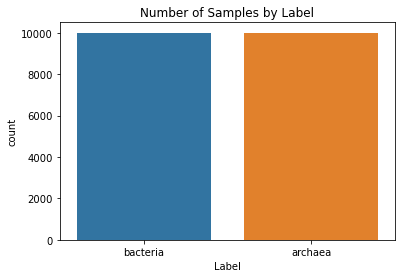

In [12]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of Samples by Label')

* Create input and output vectors.
* Process the labels.

In [13]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [14]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.85)

In [15]:
Y_test

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [16]:
max_words = 100
#max_words = 1000
max_len = 1000
#max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [17]:
#sequences_matrix[1]

### RNN
Define the RNN structure.

In [18]:
#tf.keras.layers.Embedding(
#    input_dim,
#    output_dim,
#    embeddings_initializer="uniform",
#    embeddings_regularizer=None,
#    activity_regularizer=None,
#    embeddings_constraint=None,
#    mask_zero=False,
#    input_length=None,
#    **kwargs
#)
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
#    layer = Embedding(max_words,5000,input_length=max_len)(inputs)
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [19]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer="Adam",metrics=['accuracy'])

2022-08-22 14:58:21.576504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 50)          5000      
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [20]:
#history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
#history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss')])
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.4,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
#history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
#          validation_split=0.2,callbacks=[])

Epoch 1/10
15/15 [==============================] - 15s 822ms/step - loss: 0.6832 - accuracy: 0.5667 - val_loss: 0.6244 - val_accuracy: 0.8583
Epoch 2/10
15/15 [==============================] - 13s 869ms/step - loss: 0.3783 - accuracy: 0.9083 - val_loss: 0.1172 - val_accuracy: 0.9708


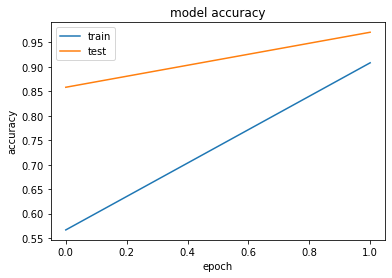

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

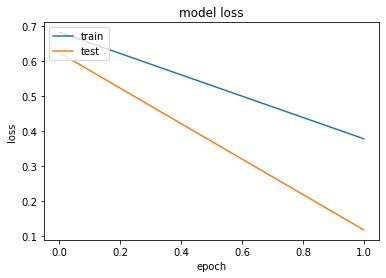

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [24]:
accr = model.evaluate(test_sequences_matrix,Y_test)

532/532 [==============================] - 46s 87ms/step - loss: 0.1197 - accuracy: 0.9667


In [25]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.120
  Accuracy: 0.967


In [26]:
accr

[0.11968215554952621, 0.966705858707428]

In [27]:
print(f'train size: [{len(X_train)}]')
print(f'test size:  [{len(X_test)}]')

train size: [3000]
test size:  [17000]
